In [1]:
import chess
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm

from icecream import ic

import time


In [2]:
SYMBOL_TO_INDEX = {
    'P': 0,
    'N': 1,
    'B': 2,
    'R': 3,
    'Q': 4,
    'K': 5,
    'p': 6,
    'n': 7,
    'b': 8,
    'r': 9,
    'q': 10,
    'k': 11,
    '.': 12
}

SCORE_TENSOR = torch.tensor([1, 0, -1]).type(torch.float32).to("cuda")

WHITE_VICOTORY = torch.tensor([1, 0, 0]).type(torch.float32).to("cuda")
BLACK_VICTORY = torch.tensor([0, 0, 1]).type(torch.float32).to("cuda")
DRAW = torch.tensor([0, 1, 0]).type(torch.float32).to("cuda")

board = chess.Board()

class FFN(nn.Module):
    def __init__(self):
        super(FFN, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(64*13, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 3),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, 64*13)  # Reshape the input to match the first layer's expected input size
        x = self.fc_layers(x)
        return x

# Create an instance of the FFN model
model = FFN()
model = model.to('cuda')


In [3]:
def boards2tensor(boards):
    batched_one_hot_boards = []
    for board in boards:
        board_str = str(board).replace('\n', ' ').split(' ')
        one_hot_encoded_board = [F.one_hot(torch.tensor(SYMBOL_TO_INDEX[symbol]), num_classes=len(SYMBOL_TO_INDEX)).flatten() for symbol in board_str]
        model_input = torch.stack(one_hot_encoded_board).type(torch.float32)
        batched_one_hot_boards.append(model_input)
    
    # Stack all board tensors to create a batch
    batched_tensor = torch.stack(batched_one_hot_boards).cuda()
    ic(batched_tensor.shape)
    return batched_tensor

def board_score(model, boards, white_to_move):
    with torch.no_grad():
        batched_boards = boards2tensor(boards)
        scores = (model(batched_boards) * SCORE_TENSOR).sum(dim=1)
        return scores if white_to_move else scores * -1 

def find_best_move(model, board, time_it=False):
    if time_it:
        start_time = time.time()

    legal_moves = list(board.legal_moves)
    boards_after_move = []
    for move in legal_moves:
        board.push(move)
        boards_after_move.append(board.copy())
        board.pop()

    # Get scores for all boards in one batch
    move_scores = board_score(model, boards_after_move, board.turn)
    
    probabilities = torch.softmax(move_scores, dim=0)
    best_move_index = torch.multinomial(probabilities, 1).item()
    best_move = legal_moves[best_move_index]

    if time_it:
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"Execution time: {execution_time} seconds")
    
    return best_move.uci()


In [4]:
find_best_move(model, board)

ic| batched_tensor.shape: torch.Size([20, 64, 13])


'd2d3'

In [5]:
board.reset()

In [6]:
def play_a_game(time_it=False):
    counter = 0
    while not board.is_game_over():
        if time_it:
            start_time = time.time()
        counter += 1
        print(counter, end='\r')
        move = find_best_move(model, board, time_it=False)
        if move is None or counter > 1000:
            break
        board.push_uci(move)
        if time_it:
            end_time = time.time()
            execution_time = end_time - start_time
            print(f"Execution time: {execution_time} seconds")
    return board.result(), counter

In [8]:
ic.disable()

In [11]:
def get_reward(board):
    result = board.result()
    if result == '1-0':
        return WHITE_VICOTORY
    elif result == '0-1':
        return BLACK_VICTORY   
    else:
        return DRAW 

def train_model(model, num_games, learning_rate, num_parallel_games):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    boards = [chess.Board() for _ in range(num_parallel_games)]
    game_memories = [[] for _ in range(num_parallel_games)]

    for _ in tqdm(range(num_games)):
        while not all(board.is_game_over() for board in boards):
            for i, board in enumerate(boards):
                if not board.is_game_over():
                    move = find_best_move(model, board)
                    board.push_uci(move)
                    game_memories[i].append(boards2tensor([board]))

        for board, game_memory in zip(boards, game_memories):
            target_tensor = get_reward(board)
            board.reset()
            loss = 0
            for board_state in game_memory:
                model_output = model(board_state)
                loss += F.cross_entropy(model_output, target_tensor.unsqueeze(0))
            loss /= len(game_memory)
            print(loss, len(game_memory))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Clear game memories for the next round
        game_memories = [[] for _ in range(num_parallel_games)]

# Example usage
train_model(model, num_games=5, learning_rate=0.001, num_parallel_games=2)



  0%|          | 0/5 [00:00<?, ?it/s]

tensor(1.1121, device='cuda:0', grad_fn=<DivBackward0>) 393
tensor(1.0171, device='cuda:0', grad_fn=<DivBackward0>) 434


 20%|██        | 1/5 [01:04<04:17, 64.36s/it]


KeyboardInterrupt: 

In [ ]:
model(torch.rand(1, 64*13).cuda())

tensor([[0., 0., 1.]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [ ]:

def material_balance(board):
    white = board.occupied_co[chess.WHITE]
    black = board.occupied_co[chess.BLACK]
    return (
        chess.popcount(white & board.pawns) - chess.popcount(black & board.pawns) +
        3 * (chess.popcount(white & board.knights) - chess.popcount(black & board.knights)) +
        3 * (chess.popcount(white & board.bishops) - chess.popcount(black & board.bishops)) +
        5 * (chess.popcount(white & board.rooks) - chess.popcount(black & board.rooks)) +
        9 * (chess.popcount(white & board.queens) - chess.popcount(black & board.queens))
    )
    
material_balance(board)

0

In [ ]:
model_output = model(boards2tensor([board]))
print(model_output.shape)
loss = F.cross_entropy(model_output, WHITE_VICOTORY.unsqueeze(0))
loss

torch.Size([1, 3])


tensor(1.1021, device='cuda:0', grad_fn=<DivBackward1>)

In [ ]:
white_wins = 0
black_wins = 0
draws = 0
ic.disable()
for i in range(1):
    board.reset()
    result, counter = play_a_game(time_it=True)
    print(counter)
    if result == '1-0':
        white_wins += 1
    elif result == '0-1':
        black_wins += 1
    else:
        draws += 1
        
print(f"White wins: {white_wins}")
print(f"Black wins: {black_wins}")
print(f"Draws: {draws}")

Execution time: 0.04900074005126953 seconds
Execution time: 0.037999629974365234 seconds
Execution time: 0.05402874946594238 seconds
Execution time: 0.042005300521850586 seconds
Execution time: 0.045995473861694336 seconds
Execution time: 0.05000019073486328 seconds
Execution time: 0.057004451751708984 seconds
Execution time: 0.04696512222290039 seconds
Execution time: 0.0690300464630127 seconds
Execution time: 0.0610048770904541 seconds
Execution time: 0.057997703552246094 seconds
Execution time: 0.10396766662597656 seconds
Execution time: 0.10499835014343262 seconds
Execution time: 0.04903602600097656 seconds
Execution time: 0.0630025863647461 seconds
Execution time: 0.05396246910095215 seconds
Execution time: 0.06296563148498535 seconds
Execution time: 0.05503654479980469 seconds
Execution time: 0.06200075149536133 seconds
Execution time: 0.06297063827514648 seconds
Execution time: 0.06203651428222656 seconds
Execution time: 0.061995506286621094 seconds
Execution time: 0.06899166107

KeyboardInterrupt: 

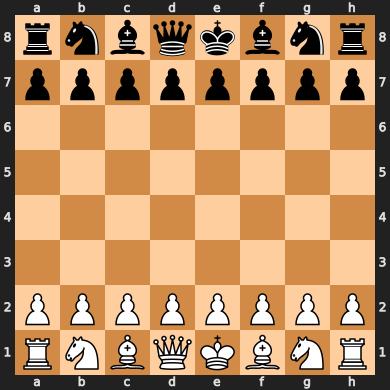

In [ ]:
board

In [ ]:
# Generate a list of all legal moves
legal_moves_list = list(board.legal_moves)

# Optionally, you can convert these moves to their string notation
legal_moves_str_list = [move.uci() for move in legal_moves_list]

# Print the list of legal moves
print(legal_moves_str_list)
print(len(legal_moves_str_list))

In [ ]:
import random

def random_legal_move(board):
    """
    Returns a random legal move for the given board.

    Args:
    board (chess.Board): The current state of the chess board.

    Returns:
    chess.Move: A random legal move.
    """
    legal_moves = list(board.legal_moves)
    legal_moves_str_list = [move.uci() for move in legal_moves]
    if legal_moves_str_list:
        return random.choice(legal_moves_str_list)
    else:
        return None  # No legal moves available

# Example usage:
# board = chess.Board()
# move = random_legal_move(board)
# print(move)


In [ ]:
counter = 0
while True:
    m = random_legal_move(board)
    counter += 1
    if m is None or board.is_game_over():
        print("game has ended", counter)
        print(board.result())
        break
    board.push_san(m)


game has ended 20
1-0


In [ ]:
board.result()

'1-0'

In [ ]:
check_game_over(board)

(True, 'Draw')

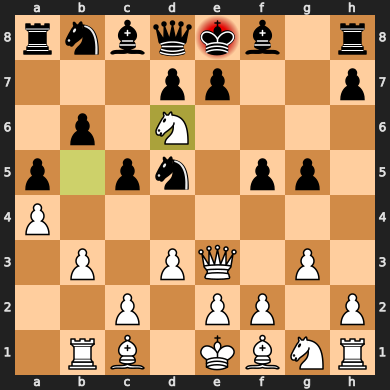

In [ ]:
board